# Class Library

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# New import for progress bars
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import KMeans

# LLM-related imports
import google.generativeai as genai
from openai import OpenAI
from together import Together

c:\Users\Chris\anaconda3\envs\bertopic_39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %run 00_lib_preprocessing.ipynb
# %run 00_lib_sqlwriter.ipynb

# # Download NLTK packages
# nltk.download('punkt')
# nltk.download('stopwords')  # Just in case stopwords are needed
# nltk.download('wordnet')  # For lemmatization support

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
class DataIngestion:
    """
    Class responsible for reading data files and performing initial data cleaning.
    """
    def __init__(self, file_path:str):
        self.file_path = file_path

    def load_data(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Loads the archives, articles, and contents DataFrames from data files.
        """
        print("[INFO] Loading data files...")
        df = pd.read_excel(self.file_path)

        return df

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
class BERTopicModeler:
    """
    Wrapper class for the BERTopic pipeline.
    """
    def __init__(self, embedding_model_name: str, max_features: int = None):
        """
        Initializes the BERTopic pipeline with SentenceTransformer, TF-IDF, and HDBSCAN.
        """
        self.embedding_model = SentenceTransformer(embedding_model_name)
        
        self.umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine', random_state=42)
        
        self.kmeans_model = KMeans(n_clusters=35, init="k-means++", n_init=1, random_state=42)  # KMeans(n_clusters=35, random_state=42) # force outliers into cluster
        
        self.hdbscan_model = HDBSCAN(
            min_cluster_size=3,
            min_samples=None,
            metric='euclidean',
            cluster_selection_epsilon=0.0,
            cluster_selection_method='eom',
            prediction_data=True
        )

        self.vectorizer_model = TfidfVectorizer(
            stop_words="english", # or None
            max_features=max_features,
            ngram_range=(1, 3),
            tokenizer=LemmaTokenizer()
        )

        self.ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
        # Enable verbose to get some internal logs from BERTopic
        self.topic_model = BERTopic(
            embedding_model=self.embedding_model,
            umap_model=self.umap_model,
            hdbscan_model=self.hdbscan_model,
            vectorizer_model=self.vectorizer_model,
            ctfidf_model=self.ctfidf_model,
            nr_topics="auto", # None, no reduction. "auto" will reduce topics using HDBSCAN
            top_n_words=10,
            verbose=True  # <--- Will print messages during training
        )

    def fit_transform(self, texts: list[str]) -> tuple[list[int], list[list[float]]]:
        """
        Fits the topic model, and returns the assigned topic labels and probabilities.
        """
        print("[INFO] Fitting BERTopic model... This may take a while.")
        topics, probs = self.topic_model.fit_transform(texts)
        print("[INFO] BERTopic fitting complete.")
        return topics, probs

    def reduce_topics(self, texts: list[str], probabilities, nr_topics: int = 20):
        """
        Reduces the number of topics to nr_topics.
        """
        print(f"[INFO] Reducing number of topics to {nr_topics}...")
        self.topic_model.reduce_topics(texts, probabilities, nr_topics=nr_topics)

    def get_topic_info(self) -> pd.DataFrame:
        """
        Returns topic information (id, count, representative words).
        """
        return self.topic_model.get_topic_info()

# ------------------------------------------------------------------
# Abstract base class for LLM usage
# ------------------------------------------------------------------

class BaseLLMClient:
    """
    Abstract base class for Large Language Model (LLM) clients.
    """
    def __init__(self, config_path: str):
        with open(config_path, 'r', encoding='utf-8') as file:
            self.config = json.load(file)

    def generate_semantic_topic(self, topic_name: str, top_keywords: str) -> str:
        """
        Method to be implemented in subclasses to generate a semantic topic.
        """
        raise NotImplementedError("Subclasses must implement this method.")


# ------------------------------------------------------------------
# Concrete LLM Clients
# ------------------------------------------------------------------

class GoogleAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for Google Generative AI.
    """
    def generate_semantic_topic(self, topic_name: str, top_keywords: str) -> str:
        genai.configure(api_key=self.config["google_api_key"])
        model = genai.GenerativeModel("gemma-2-2b-it")
        input_text = f"{topic_name}, {top_keywords}"
        prompt = (
            f"Create semantic topics (max 10 words) "
            f"from the following keywords: {input_text}"
        )
        response = model.generate_content(prompt)
        return response.text


class OpenAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for OpenAI (proxied via a custom base_url).
    """
    def generate_semantic_topic(self, input_text: str) -> str:
        prompt = (
            "Create a short semantic topic label (no more than 3 words) "
            f"from the following text: {input_text}"
        )

        response = self.client.chat.completions.create(
            model="deepseek-ai/DeepSeek-R1",
            messages=[
                {"role": "system", "content": "You are a concise, helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000,
            temperature=0.7,
            top_p=0.7,
            top_k=50,
            repetition_penalty=1,
            stop=["<|end_of_sentence|>"],
            stream=True
        )

        semantic_topic = ""
        for token in response:
            if hasattr(token, 'choices') and token.choices:
                semantic_topic += token.choices[0].delta.content

        return semantic_topic


class TogetherAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for the Together API.
    """
    def __init__(self, config_path: str):
        super().__init__(config_path)
        os.environ["TOGETHER_API_KEY"] = self.config["together_api_key"]
        self.client = Together(api_key=self.config["together_api_key"])

    def generate_semantic_topic(self, topic_name: str, top_keywords: str, max_num_of_output_words:int = 3) -> str:
        """
        Generates a concise semantic topic label from the topic name and keywords.
        """

        # Turn list of keywords into a short string:
        keywords_text = top_keywords

        # Create a clear, direct instruction for the LLM:
        prompt = f"""
            You are an expert in Internet and technologies domain and topic modeling.
            Your task: Create a high level research theme (<={max_num_of_output_words} words) that represents these keywords.

            Topic Name: {topic_name}
            Representative Keywords: {keywords_text}

            Constraints:
            1. ONLY output the research theme label itself - no explanations or additional text
            2. Maximum {max_num_of_output_words} words
            3. Must identify a theme that is coherent with the keywords collection
            4. Use terminology appropriate for academic knowledge organization
            """

        response = self.client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
            messages=[
                {"role": "system", "content": "You are a precise topic labeling assistant that generates only the requested label with no additional text."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100, # short label
            temperature=0.1, # to prioritize precision instead of creativity
            top_p=0.9, # allow some variety but still maintaining focus
            top_k=40,
            repetition_penalty=1.1, # prevent repetitive output
            stop=["\n", "."], # stop tokens
            stream=True
        )

        semantic_topic = ""
        for token in response:
            if hasattr(token, 'choices') and token.choices:
                semantic_topic += token.choices[0].delta.content

        # Cleanup: strip any leading/trailing whitespace/newlines:
        return semantic_topic.strip()


# ------------------------------------------------------------------
# DataFrame Processor for applying semantic topic generation
# ------------------------------------------------------------------

class SemanticTopicDataFrameProcessor:
    @staticmethod
    def add_semantic_topic_column(
        df: pd.DataFrame,
        semantic_topic_generator: BaseLLMClient,
        name_col: str = 'Name',
        representation_col: str = 'Representation',
        output_col: str = 'Semantic_Topic', 
        max_num_of_output_words  = 3
    ) -> pd.DataFrame:
        """
        Use an LLM client to create a semantic topic for each row, then store the result in new column.

        :param df: DataFrame containing columns for name_col and representation_col
        :param semantic_topic_generator: An instance of a BaseLLMClient subclass
        :param name_col: Column name that has a descriptive 'Name'
        :param representation_col: Column name that has text to be summarized or used for generation
        :param output_col: Name of the new column for storing the generated semantic topic
        :return: DataFrame with the new semantic topic column.
        """

        # --- Option A: A progress bar via a for-loop ---
        # Initialize an empty list to collect results
        results = []
        print("[INFO] Generating semantic topics with LLM (this may take a while).")
        for idx in tqdm(range(len(df)), desc="LLM Generation"):
            row = df.iloc[idx]
            topic_name = row[name_col]
            topic_keywords = row[representation_col]
            topic = semantic_topic_generator.generate_semantic_topic(topic_name, topic_keywords,max_num_of_output_words) 
            results.append(topic)

        df[output_col] = results

        return df


import json
import pandas as pd

class DataFrameExporter:
    """
    Class responsible for exporting a DataFrame to CSV or excel.    
    """
    def __init__(self, config_path: str):
        with open(config_path, "r", encoding="utf-8") as f:
            self.config = json.load(f)

    def export_to_excel(self, df: pd.DataFrame, param_name:str) -> None:
        """
        Reads the 'topic_modeling_output_excel_filename' from the config,
        then writes the DataFrame to that excel file.
        """
        output_file = self.config.get(param_name, "default_output.xlsx")
        df.to_excel(output_file, index=False)
        print(f"[INFO] Successfully exported DataFrame to {output_file}")

## Start Processing

In [5]:
# ------------------------------------------------------------------
# Main usage (end-to-end pipeline)
# ------------------------------------------------------------------

# STEP 1: Load data
topics_over_time_df = pd.read_excel('results/topics_over_time.xlsx')
display(topics_over_time_df.head())
display (topics_over_time_df.shape)

topics_info_df = pd.read_excel('results/topic_info_df_gist_kmeans.xlsx')
display(topics_info_df.head())
display (topics_info_df.shape)

,Topic,Words,Frequency,Timestamp,Semantic_Topic,Name
0,1,"internet-based research, subject ., researcher...",1,1995-12-21 08:19:40.800,1 Digital Inequality Among Older Adults,1 Digital Inequality Among Older Adults
1,3,"cgi, perl, , cgi, cgi ,, perl ,",3,1995-12-21 08:19:40.800,3 Public Library Services and Community Engage...,3 Public Library Services and Community Engage...
2,4,"amv, amv scene, fan production, scene, . reward",3,1995-12-21 08:19:40.800,4 Transmedia Fan Fiction and Personal Branding...,4 Transmedia Fan Fiction and Personal Branding...
3,5,"cash, digital cash, electronic cash, cash , el...",3,1995-12-21 08:19:40.800,5 Digital Currencies and Electronic Payment Sy...,5 Digital Currencies and Electronic Payment Sy...
4,6,"kid ,, kid, book review, child , internet, 's ...",1,1995-12-21 08:19:40.800,6 Distance Education and Open Educational Reso...,6 Distance Education and Open Educational Reso...


(844, 6)

,Topic,Count,Name,CustomName,Representation,Representative_Docs,Document_%,Semantic_Topic
0,0,87,0_open source_floss_linux_source software,"open source, floss, linux, source software, op...","['open source', 'floss', 'linux', 'source soft...",[' starting with eric raymond\'s groundbreakin...,3.61,0 Open Source Software Development and Free Li...
1,1,34,1_digital skill_elderly_digital inequality_skill,"digital skill, elderly, digital inequality, sk...","['digital skill', 'elderly', 'digital inequali...",['the creative industries workforce requires e...,1.41,1 Digital Inequality Among Older Adults
2,2,95,2_bot_qanon_troll_election,"bot, qanon, troll, election, disinformation, d...","['bot', 'qanon', 'troll', 'election', 'disinfo...",['an internet troll is a person who deliberate...,3.94,2 Social Media Disinformation Detection and Bo...
3,3,49,3_public library_library_public_patron,"public library, library, public, patron, libra...","['public library', 'library', 'public', 'patro...",[' this article presents findings from the pub...,2.03,3 Public Library Services and Community Engage...
4,4,64,4_transmedia_fan_fiction_street art,"transmedia, fan, fiction, street art, photo, i...","['transmedia', 'fan', 'fiction', 'street art',...",['the covid- pandemic accelerated the importan...,2.65,4 Transmedia Fan Fiction and Personal Branding...


(35, 8)

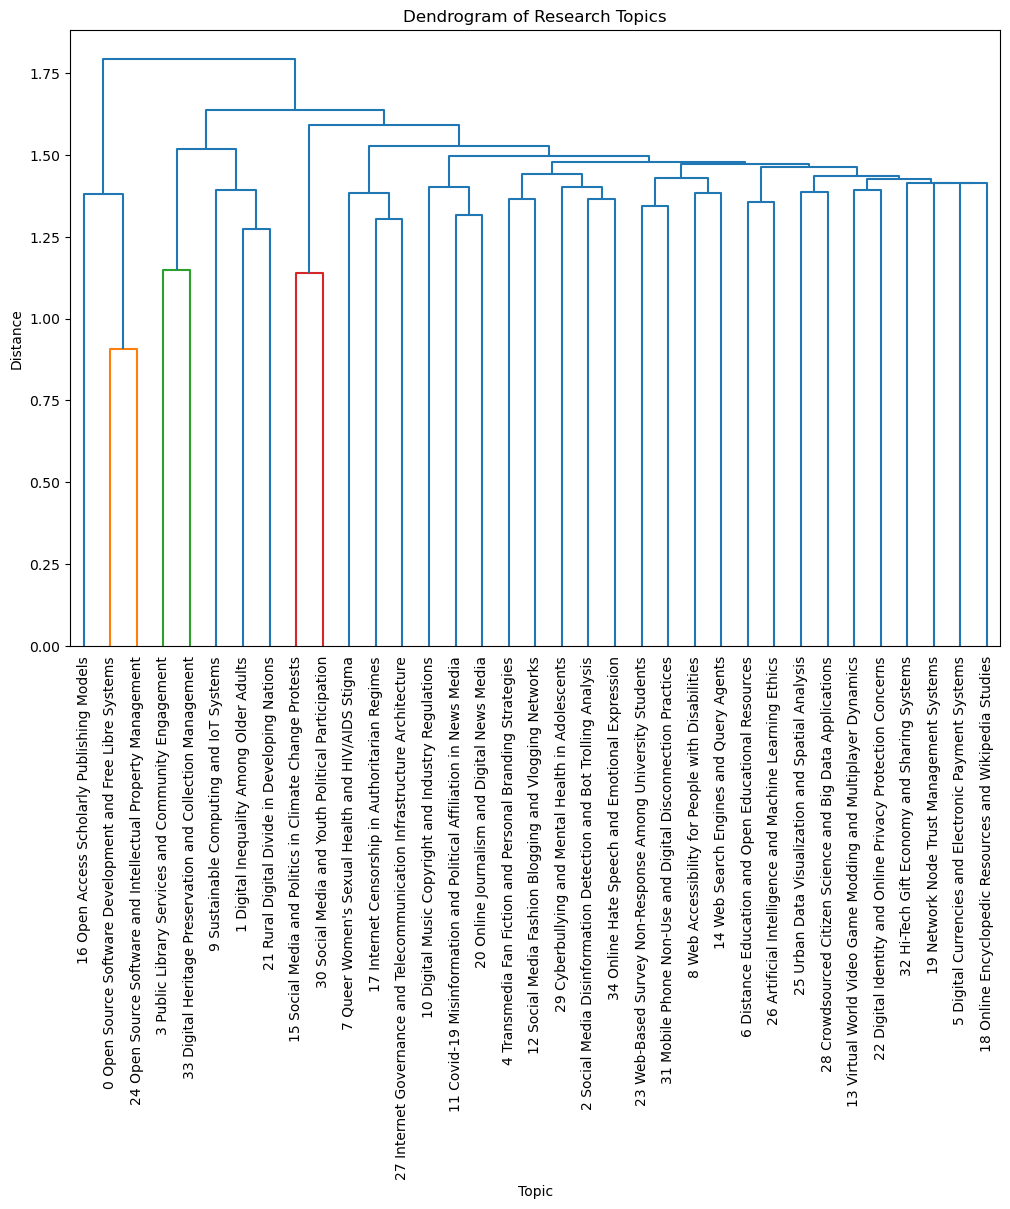

,Topic,Count,Name,CustomName,Representation,Representative_Docs,Document_%,Semantic_Topic,Cluster
0,0,87,0_open source_floss_linux_source software,"open source, floss, linux, source software, op...","['open source', 'floss', 'linux', 'source soft...",[' starting with eric raymond\'s groundbreakin...,3.61,0 Open Source Software Development and Free Li...,1
1,1,34,1_digital skill_elderly_digital inequality_skill,"digital skill, elderly, digital inequality, sk...","['digital skill', 'elderly', 'digital inequali...",['the creative industries workforce requires e...,1.41,1 Digital Inequality Among Older Adults,3


In [6]:
# STEP 2: Identify themes using Hierarchical Clustering

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

df = topics_info_df

# Combine keywords into text data
text_data = df['Representation'].apply(lambda x: ', '.join(eval(x)))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_data)

# Perform Hierarchical Clustering
Z = linkage(tfidf_matrix.toarray(), method='ward')

# Plot Dendrogram (optional)
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=df['Semantic_Topic'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Research Topics")
plt.xlabel("Topic")
plt.ylabel("Distance")
plt.show()

# Assign Clusters (Themes)
threshold = 1.5  # Adjust threshold based on dendrogram visualization
df['Cluster'] = fcluster(Z, t=threshold, criterion='distance')
display(df.head(2))
topics_info_df = df
topics_info_df.to_excel('results/topics_themes_hierarchy.xlsx', index=False)

In [7]:
# Group Topics by Themes
themes = {}
for theme_id in df['Cluster'].unique():
    grouped_terms = df[df['Cluster'] == theme_id]['Representation'].apply(lambda x: ', '.join(eval(x))).tolist()
    flattened_terms = ', '.join(grouped_terms)
    flattened_terms = re.sub(r'[^\w\s,]', '', flattened_terms)

    themes[f'{theme_id}'] = flattened_terms

# Create the theme_df DataFrame
theme_df = pd.DataFrame(list(themes.items()), columns=['Cluster', 'Cluster_Terms'])
display(theme_df.head())
theme_df.to_excel('results/themes_info_hierarchy.xlsx', index=False)

,Cluster,Cluster_Terms
0,1,"open source, floss, linux, source software, op..."
1,3,"digital skill, elderly, digital inequality, sk..."
2,6,"bot, qanon, troll, election, disinformation, d..."
3,2,"public library, library, public, patron, libra..."
4,5,"queer, shame, hiv, woman, gender, sexual, gay,..."


In [8]:
# STEP 3: Choose an LLM client for semantic topic generation (example: Together)
llm_client = TogetherAISemanticTopicClient("config/config.json")

# STEP 5: Add semantic topics to the topic_info_df
theme_df = SemanticTopicDataFrameProcessor.add_semantic_topic_column(
    df=theme_df,
    semantic_topic_generator=llm_client,
    name_col="Cluster",
    representation_col="Cluster_Terms",
    output_col="Semantic_Theme"
)

display(theme_df)
theme_df.to_excel('results/themes_info_hierarchy.xlsx', index=False)

[INFO] Generating semantic topics with LLM (this may take a while).


LLM Generation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


,Cluster,Cluster_Terms,Semantic_Theme
0,1,"open source, floss, linux, source software, op...",Open Source Systems
1,3,"digital skill, elderly, digital inequality, sk...",Digital Divide Research
2,6,"bot, qanon, troll, election, disinformation, d...",Digital Media Studies
3,2,"public library, library, public, patron, libra...",Digital Library Science
4,5,"queer, shame, hiv, woman, gender, sexual, gay,...",Internet Governance Politics
5,4,"twitter, tweet, political, social medium, medi...",Social Media Activism
